<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/PDAssumedLGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.optimize import fsolve
from scipy.stats import norm

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
warnings.filterwarnings('ignore') #Disable warning
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Define Risk Weight
data = {
    'Asset classes': [
        'Storng',
        'Good',
        'Satisfactory',
        'Weak',
        'Default'
    ],
    # Expect Loss Risk Weight
    'EL RW': [
        0.05,
        0.1,
        0.35,
        1,
        6.25
    ],
    # Capital Risk Weight
    'C RW': [
        0.7,
        0.9,
        1.15,
        2.5,
        0
    ]
}

df = pd.DataFrame(data)

# Show table
df

,Asset classes,EL RW,C RW
0,Storng,0.05,0.70
1,Good,0.10,0.90
2,Satisfactory,0.35,1.15
3,Weak,1.00,2.50
4,Default,6.25,0.00


In [4]:
# Calculate loss
df['EL'] = df['EL RW'] * 0.08
df['K'] = df['C RW'] * 0.08
df['Total loss'] = df[['EL', 'K']].sum(axis = 1)

# Show table
df

,Asset classes,EL RW,C RW,EL,K,Total loss
0,Storng,0.05,0.70,0.004,0.056,0.06
1,Good,0.10,0.90,0.008,0.072,0.08
2,Satisfactory,0.35,1.15,0.028,0.092,0.12
3,Weak,1.00,2.50,0.080,0.200,0.28
4,Default,6.25,0.00,0.500,0.000,0.50


In [5]:
# Assumed 50% LGD
LGD = 0.5

# Calculate PD
df['PD Diff'] = df['K'] / LGD
df['PD Downturn'] = df['Total loss'] / LGD
df['PD TTC'] = df['PD Downturn'] - (df['K'] / LGD)

# Show table
df

,Asset classes,EL RW,C RW,EL,K,Total loss,PD Diff,PD Downturn,PD TTC
0,Storng,0.05,0.70,0.004,0.056,0.06,0.112,0.12,0.008
1,Good,0.10,0.90,0.008,0.072,0.08,0.144,0.16,0.016
2,Satisfactory,0.35,1.15,0.028,0.092,0.12,0.184,0.24,0.056
3,Weak,1.00,2.50,0.080,0.200,0.28,0.400,0.56,0.160
4,Default,6.25,0.00,0.500,0.000,0.50,0.000,1.00,1.000


In [6]:
# Define parameters
PDDownturn = df['PD Downturn'].values[:-1] #Exclude 'Default' class
PDTTC = df['PD TTC'].values[:-1] #Exclude 'Default' class

# Define asset correlation function for solver
def R(x):
  ZDownturn = norm.ppf(PDDownturn)
  ZShift = np.sqrt(x / (1 - x)) * norm.ppf(0.999)
  ZPortion = np.sqrt(1 / (1 - x)) * norm.ppf(PDTTC)
  target = ZShift + ZPortion
  error = (ZDownturn - target) ** 2 #Square error
  return error

# Initial guess
x0 = 0.01 * np.ones(PDDownturn.size)
  
# Solver
Rho = fsolve(R, x0)

# Results
for a, r in zip(df['Asset classes'][:-1], Rho):
  print(f'{a}: {r:.4f}')

Storng: 0.1915
Good: 0.1591
Satisfactory: 0.0876
Weak: 0.1349


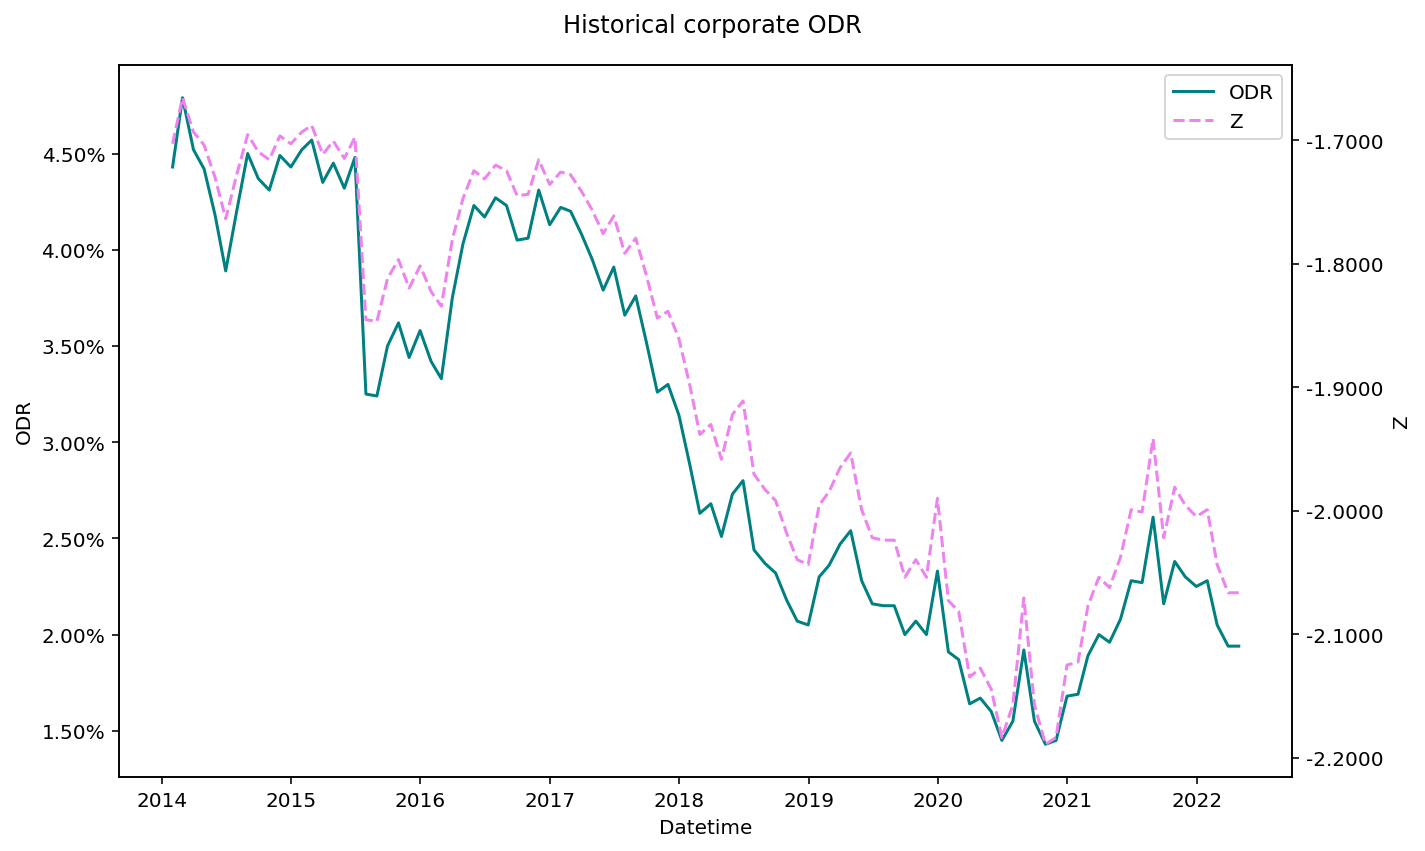

In [7]:
# Simulate PD from estimated asset correlation and reference portfolio
# Import corporate ODR
odr = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/CorporateODR.csv'
)
odr['Z'] = norm.ppf(odr['ODR'])
odr.index = pd.date_range(
  start = '31/1/2014',
  periods = odr.shape[0],
  freq = 'M'
) #Add some dates

# Plot
fig = plt.figure(figsize = (10, 6))
fig.suptitle('Historical corporate ODR')
ax = fig.add_subplot(111)
plot1 = ax.plot(
  odr.index,
  odr['ODR'],
  color = 'teal',
  label = 'ODR'
)
ax2 = ax.twinx()
plot2 = ax2.plot(
  odr.index,
  odr['Z'],
  color = 'violet',
  linestyle = '--',
  label = 'Z'
)
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100))
)
ax2.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '{0:.4f}'.format(x))
)
ax.set_xlabel('Datetime')
ax.set_ylabel('ODR')
ax2.set_ylabel('Z')
# Added these legend
plts = plot1 + plot2
labs = [l.get_label() for l in plts]
ax.legend(plts, labs, loc = 0)
fig.tight_layout()
plt.show()

In [8]:
# Create parameters for simulation
mean = norm.ppf(odr['ODR'].mean()) / np.sqrt(1 - Rho)
std = np.sqrt(Rho) / np.sqrt(1 - Rho)

# Z Simulation
for m, s, label in zip(mean, std, df['Asset classes'][:-1]):
  odr[f'Z_{label}'] = (odr['Z'] - m) / s

In [9]:
# PD Simulation
for r, ttc, label in zip(Rho, df['PD TTC'][:-1],  df['Asset classes'][:-1]):
  odr[f'PD_{label}'] = norm.cdf(
      (norm.ppf(ttc) + np.sqrt(r) * odr[f'Z_{label}']) / \
      np.sqrt(1 - r)
  )

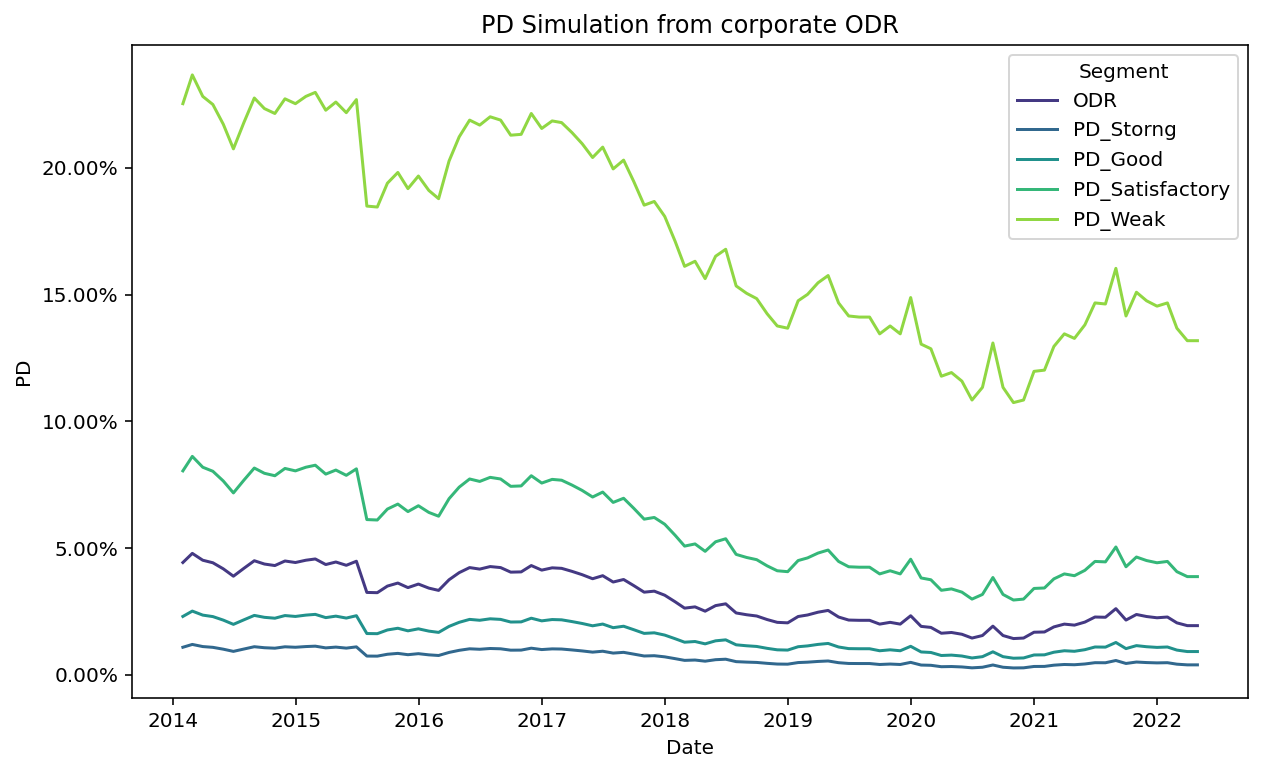

In [10]:
# Plot
plt.figure(figsize = (10, 6))
ax = sns.lineplot(
    x = 'Date',
    y = 'PD',
    data = odr[
        ['ODR', 'PD_Storng', 'PD_Good', 'PD_Satisfactory', 'PD_Weak']
    ].melt(
        var_name = 'Segment',
        value_name = 'PD',
        ignore_index = False
    ).reset_index().rename(
        columns = {
            'index': 'Date'
        }
    ),
    hue = 'Segment',
    legend = 'full',
    palette = 'viridis',
    ci = None
)
ax.set_title('PD Simulation from corporate ODR')
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100))
)
plt.show()